In [1]:
# Problem Statement:
# This analysis aims to identify distinct customer segments based on purchasing behaviors and demographics,
# predict customer loyalty scores, and develop actionable insights to improve marketing strategies and
# increase customer retention. The business objective is to understand which factors most influence
# purchase amounts and loyalty, and develop targeted marketing campaigns for different customer segments.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set the style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [4]:
# Load the dataset
df = pd.read_csv('Customer_Purchasing_Behaviors.csv')

In [5]:
# 1. Exploratory Data Analysis (EDA)
print("Data Overview:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Data Overview:
   user_id  age  annual_income  purchase_amount  loyalty_score region  \
0        1   25          45000              200            4.5  North   
1        2   34          55000              350            7.0  South   
2        3   45          65000              500            8.0   West   
3        4   22          30000              150            3.0   East   
4        5   29          47000              220            4.8  North   

   purchase_frequency  
0                  12  
1                  18  
2                  22  
3                  10  
4                  13  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             238 non-null    int64  
 1   age                 238 non-null    int64  
 2   annual_income       238 non-null    int64  
 3   purchase_amount     238 non-null    

In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
user_id               0
age                   0
annual_income         0
purchase_amount       0
loyalty_score         0
region                0
purchase_frequency    0
dtype: int64


In [7]:
# Visualize distributions of key variables
plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

Text(0.5, 1.0, 'Age Distribution')

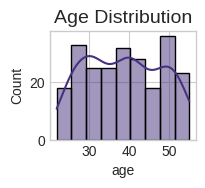

In [8]:
# Age distribution
plt.subplot(3, 3, 1)
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution', fontsize=14)

Text(0.5, 1.0, 'Annual Income Distribution')

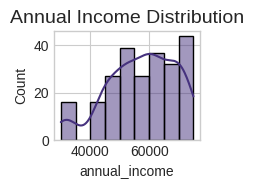

In [9]:
# Annual income distribution
plt.subplot(3, 3, 2)
sns.histplot(df['annual_income'], kde=True)
plt.title('Annual Income Distribution', fontsize=14)

Text(0.5, 1.0, 'Purchase Amount Distribution')

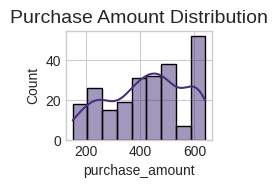

In [10]:
# Purchase amount distribution
plt.subplot(3, 3, 3)
sns.histplot(df['purchase_amount'], kde=True)
plt.title('Purchase Amount Distribution', fontsize=14)

Text(0.5, 1.0, 'Loyalty Score Distribution')

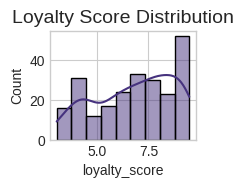

In [11]:
# Loyalty score distribution
plt.subplot(3, 3, 4)
sns.histplot(df['loyalty_score'], kde=True)
plt.title('Loyalty Score Distribution', fontsize=14)

Text(0.5, 1.0, 'Purchase Frequency Distribution')

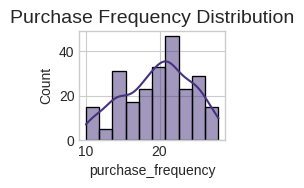

In [12]:
# Purchase frequency distribution
plt.subplot(3, 3, 5)
sns.histplot(df['purchase_frequency'], kde=True)
plt.title('Purchase Frequency Distribution', fontsize=14)

Text(0.5, 1.0, 'Customers by Region')

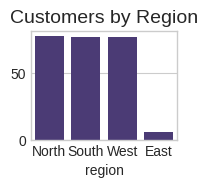

In [13]:
# Region distribution
plt.subplot(3, 3, 6)
region_counts = df['region'].value_counts()
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title('Customers by Region', fontsize=14)

Text(0.5, 1.0, 'Purchase Amount by Region')

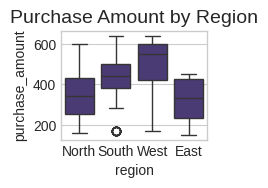

In [14]:
# Purchase amount by region
plt.subplot(3, 3, 7)
sns.boxplot(x='region', y='purchase_amount', data=df)
plt.title('Purchase Amount by Region', fontsize=14)

In [15]:
# Loyalty score by region
plt.subplot(3, 3, 8)
sns.boxplot(x='region', y='loyalty_score', data=df)
plt.title('Loyalty Score by Region', fontsize=14)

plt.tight_layout()
plt.savefig('distributions.png')
plt.close()

In [20]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('correlation.png')
plt.close()

# Scatter plots for key relationships
plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

In [21]:
# Age vs Purchase Amount
plt.subplot(2, 2, 1)
sns.scatterplot(x='age', y='purchase_amount', hue='region', data=df, alpha=0.7)
plt.title('Age vs Purchase Amount', fontsize=14)

# Income vs Purchase Amount
plt.subplot(2, 2, 2)
sns.scatterplot(x='annual_income', y='purchase_amount', hue='region', data=df, alpha=0.7)
plt.title('Annual Income vs Purchase Amount', fontsize=14)

# Loyalty Score vs Purchase Frequency
plt.subplot(2, 2, 3)
sns.scatterplot(x='loyalty_score', y='purchase_frequency', hue='region', data=df, alpha=0.7)
plt.title('Loyalty Score vs Purchase Frequency', fontsize=14)

# Age vs Loyalty Score
plt.subplot(2, 2, 4)
sns.scatterplot(x='age', y='loyalty_score', hue='region', data=df, alpha=0.7)
plt.title('Age vs Loyalty Score', fontsize=14)

plt.tight_layout()
plt.savefig('scatter_relationships.png')
plt.close()

In [22]:
# 2. Data Preprocessing
# Create a copy of the dataset for processing
df_processed = df.copy()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_processed, columns=['region'], drop_first=True)

# Scale the features for clustering and modeling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded.drop(['user_id'], axis=1))
scaled_df = pd.DataFrame(scaled_features, columns=df_encoded.columns[1:])

In [23]:
# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [24]:
# 3. Customer Segmentation using K-means Clustering
# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

In [26]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.close()

In [27]:
# Based on elbow method, choose optimal k (let's assume k=4 for now)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_encoded['cluster'] = kmeans.fit_predict(scaled_df)

In [28]:
# Save the clustering model
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

In [29]:
# Analyze clusters
cluster_analysis = df_encoded.groupby('cluster').mean()
print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
            user_id        age  annual_income  purchase_amount  loyalty_score  \
cluster                                                                         
0        125.958904  47.191781   67260.273973       552.054795       8.457534   
1        120.534247  30.397260   48863.013699       304.383562       5.123288   
2        113.560000  41.653333   61480.000000       475.600000       7.557333   
3        113.529412  24.529412   33823.529412       182.941176       3.458824   

         purchase_frequency  region_North  region_South  region_West  
cluster                                                               
0                 23.808219      0.109589      0.000000     0.890411  
1                 16.041096      0.821918      0.000000     0.150685  
2                 21.413333      0.133333      0.826667     0.000000  
3                 11.588235      0.000000      0.882353     0.058824  


In [30]:
# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_df)
df_encoded['pca1'] = pca_result[:, 0]
df_encoded['pca2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', palette='viridis', data=df_encoded, s=100, alpha=0.7)
plt.title('Customer Segments Visualization using PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('clusters_pca.png')
plt.close()

In [31]:
# 4. Predictive Modeling - Predicting Loyalty Score
# Prepare data for modeling
X = df_encoded.drop(['user_id', 'loyalty_score', 'cluster', 'pca1', 'pca2'], axis=1)
y = df_encoded['loyalty_score']


In [32]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [33]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")



Model Evaluation:
RMSE: 0.0421
R² Score: 0.9996


In [35]:
# Cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")


Cross-Validation R² Scores: [0.97701426 0.99999935 0.99999933 0.99999925 0.99999924]
Mean CV R² Score: 0.9954


In [36]:
# Save the model
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [37]:
# 5. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Predicting Loyalty Score', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()



Feature Importance:
              Feature  Importance
1       annual_income    0.437437
0                 age    0.272937
2     purchase_amount    0.210433
3  purchase_frequency    0.078256
5        region_South    0.000659
4        region_North    0.000219
6         region_West    0.000058


In [38]:
# 6. Advanced Cluster Analysis
# Add the cluster labels back to the original dataframe
df['cluster'] = df_encoded['cluster']


In [39]:
# Create a detailed cluster profile
cluster_profiles = pd.DataFrame()
for cluster in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster]
    cluster_profile = {
        'Cluster Size': len(cluster_data),
        'Avg Age': cluster_data['age'].mean(),
        'Avg Income': cluster_data['annual_income'].mean(),
        'Avg Purchase': cluster_data['purchase_amount'].mean(),
        'Avg Loyalty': cluster_data['loyalty_score'].mean(),
        'Avg Purchase Freq': cluster_data['purchase_frequency'].mean(),
        'North %': (cluster_data['region'] == 'North').mean() * 100,
        'South %': (cluster_data['region'] == 'South').mean() * 100,
        'East %': (cluster_data['region'] == 'East').mean() * 100,
        'West %': (cluster_data['region'] == 'West').mean() * 100
    }
    cluster_profiles = pd.concat([cluster_profiles, pd.DataFrame(cluster_profile, index=[f'Cluster {cluster}'])])

print("\nDetailed Cluster Profiles:")
print(cluster_profiles)



Detailed Cluster Profiles:
           Cluster Size    Avg Age    Avg Income  Avg Purchase  Avg Loyalty  \
Cluster 0            73  47.191781  67260.273973    552.054795     8.457534   
Cluster 1            73  30.397260  48863.013699    304.383562     5.123288   
Cluster 2            75  41.653333  61480.000000    475.600000     7.557333   
Cluster 3            17  24.529412  33823.529412    182.941176     3.458824   

           Avg Purchase Freq    North %    South %    East %     West %  
Cluster 0          23.808219  10.958904   0.000000  0.000000  89.041096  
Cluster 1          16.041096  82.191781   0.000000  2.739726  15.068493  
Cluster 2          21.413333  13.333333  82.666667  4.000000   0.000000  
Cluster 3          11.588235   0.000000  88.235294  5.882353   5.882353  


In [40]:
# 7. Age Group Analysis
# Create age groups
age_bins = [18, 25, 35, 45, 55, 65]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

In [41]:
# Analysis by age group
age_group_analysis = df.groupby('age_group').agg({
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'purchase_frequency': 'mean'
}).reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(x='age_group', y='purchase_amount', data=age_group_analysis)
plt.title('Average Purchase Amount by Age Group', fontsize=16)
plt.savefig('age_group_purchase.png')
plt.close()

In [42]:
# 8. Income Level Analysis
# Create income levels
income_bins = [0, 40000, 50000, 60000, 70000, 100000]
income_labels = ['<$40K', '$40K-$50K', '$50K-$60K', '$60K-$70K', '$70K+']
df['income_level'] = pd.cut(df['annual_income'], bins=income_bins, labels=income_labels)


In [43]:
# Analysis by income level
income_level_analysis = df.groupby('income_level').agg({
    'purchase_amount': 'mean',
    'loyalty_score': 'mean',
    'purchase_frequency': 'mean'
}).reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(x='income_level', y='purchase_amount', data=income_level_analysis)
plt.title('Average Purchase Amount by Income Level', fontsize=16)
plt.savefig('income_level_purchase.png')
plt.close()

In [44]:
# Save the processed data
df.to_csv('processed_customer_data.csv', index=False)